In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/deniska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def stem_text(sentence, stopwords=[None]):
    return " ".join([stemmer.stem(word.decode("utf-8")) for word in sentence.split(" ")
                       if word.decode("utf-8") not in stopwords])

In [3]:
# our data
data = pd.read_csv("X_train.csv")

#our stemmer
stemmer = nltk.stem.snowball.RussianStemmer(ignore_stopwords=True)  

#our tokenizer
tokenizer = nltk.tokenize.WordPunctTokenizer()

#now stem our comments
data.comment = data.comment.apply(stem_text)

#turn our data inton numpy arrays
comments = data.comment.as_matrix()
ratings = data.reting.as_matrix()

In [4]:
#word - token pairs for further tokenization
enumerated_text = enumerate(set([0] + tokenizer.tokenize(" ".join(comments))))
word2token = {w : t for t, w in enumerated_text}

#size of our vocab for the embeddin layer
VOCAB_SIZE = len(word2token.keys())

In [5]:
#split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(comments, ratings, test_size=0.3)
Y_train = Y_train.round()

In [6]:
#standart helper functions

def tokenize_sentence(sentence):
    sentence = np.asarray([word2token[word] for word in tokenizer.tokenize(sentence)])
    return sentence
    
def onehot(y, n_class=5):
    Y = np.zeros((len(y), n_class))
    Y[np.arange(len(y)), y] = 1
    return Y

def sample_train_batch(batch_size):
    ixes = np.random.choice(range(len(X_train)), batch_size, False)
    x_batch = np.array([tokenize_sentence(X_train[i]) for i in ixes])
    y_batch = np.array([Y_train[i] for i in ixes]).astype("int32")
    maxlen = len(max(x_batch, key=len))
    
    return np.array([np.pad(sen, (0, maxlen - len(sen)), "constant", constant_values=(0)) for sen in x_batch]), \
            onehot(y_batch - 1)

In [7]:
%env THEANO_FLAGS=device=gpu0,floatX=float32

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



env: THEANO_FLAGS=device=gpu0,floatX=float32


Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN not available)


In [8]:
#define our net

inputSentence = T.matrix("Sentancia", "int32")
inputClass = T.matrix("Rating", "float32")

net = InputLayer((None, None), inputSentence)
net = EmbeddingLayer(net, VOCAB_SIZE, 512)

net = LSTMLayer(net, 256) 
net = DropoutLayer(net, 0.5)
net = LSTMLayer(net, 256)
net = DropoutLayer(net, 0.5)
net = LSTMLayer(net, 256, only_return_final=True)

net = DenseLayer(net, 256)
net = DenseLayer(net, 128)
net = DenseLayer(net, 5, nonlinearity=T.nnet.softmax)

In [9]:
output = get_output(net)
loss = lasagne.objectives.categorical_crossentropy(output, inputClass).mean()

In [10]:
params = get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params)
train_fun = theano.function([inputSentence, inputClass], loss, updates=updates, allow_input_downcast=True)
predict = theano.function([inputSentence], output, allow_input_downcast=True)

39800


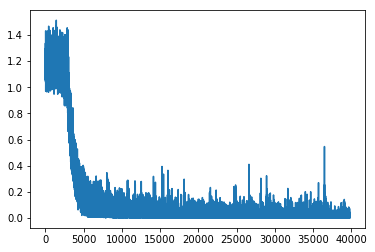

In [ ]:
#training loop

loss = list()
num_epochs = 40000
batch_size = 90
display_epoch = 200

for ep in range(num_epochs):
    x, y = sample_train_batch(batch_size)
    
    loss.append(train_fun(x, y))
    
    if ep % display_epoch == 0:
        clear_output()
        clear_output()
        print ep
        plt.plot(loss)
        plt.show()


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = np.array([predict([tokenize_sentence(samp)]).argmax() + 1 for samp in X_test], 
                       dtype="float64").ravel()
mae = mean_absolute_error(Y_test, predictions)
mse = mean_squared_error(Y_test, predictions)

print "Your MAE score is:", mae
print "Yout MSE score is", mse

Your MAE score is: 0.887705794313
Yout MSE score is 1.63667735728
